In [1]:
import pandas as pd
import time
import numpy as np
import pickle
#from ClusteringPredictiveModel import ClusteringPredictiveModel
#from sklearn.cross_validation import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from  matplotlib import pyplot
from sklearn.ensemble import RandomForestClassifier
from LastStateEncoder import LastStateEncoder
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
import difflib as diff

In [2]:
common=pd.read_csv('common cases.csv',sep=';')

In [3]:
uncommon=pd.read_csv('uncommon cases.csv',sep=';')

In [2]:
data=pd.read_csv('BPIC 2017 just complete cases.csv',sep=';')

In [3]:
with open ('Clustering/SimilarityMatrix.pkl', 'rb') as fp:
     similarities = pickle.load(fp)

In [4]:
with open ('Clustering/train_KMedoide.pkl', 'rb') as fp:
     train_KMedoide = pickle.load(fp)

In [5]:
with open ('Clustering/test_KMedoide.pkl', 'rb') as fp:
     test_KMedoide = pickle.load(fp)

In [6]:
with open ('Clustering/sample_cases_KMedoide.pkl', 'rb') as fp:
     sample_cases_KMedoide = pickle.load(fp)

In [7]:
#global case_id_col,event_col,timestamp_col,label_col,pos_label,numeric_cols,meta_event_data,other_col,variant_col

case_id_col = "Case ID"
event_col = "Activity"
timestamp_col =["Complete Timestamp",'Start Timestamp']
label_col = 'lbl'
pos_label = 'A_Pending'
cat_cols = ['Resource','(case) LoanGoal','(case) ApplicationType'] 
numeric_cols = [ '(case) RequestedAmount',label_col]  
meta_event_data=['EventOrigin','OfferID','Unnamed: 0','Transition','milli_seconds',
          'EventID','lifecycle:transition','days','D_seconds',
          'Accepted', 'Selected' ,
          'FirstWithdrawalAmount', 'MonthlyCost', 'NumberOfTerms','outcome',
          'Variant', 'Action', 'CreditScore','OfferedAmount'
          ]
other_col= '(case) RequestedAmount'
variant_col='Variant index'

In [8]:
data.drop(meta_event_data,axis=1,inplace=True)
data.drop(variant_col,axis=1,inplace=True)

In [9]:
from sklearn.preprocessing import LabelEncoder
lb_make = LabelEncoder()
data['Activity'] = lb_make.fit_transform(data['Activity'])

data.head() #Results in appending a new column to df

,Case ID,Activity,Resource,(case) ApplicationType,(case) LoanGoal,(case) RequestedAmount,lbl
0,Application_652823628,4,User_1,New credit,Existing loan takeover,20000.0,A_Pending
1,Application_652823628,8,User_1,New credit,Existing loan takeover,20000.0,A_Pending
2,Application_652823628,3,User_1,New credit,Existing loan takeover,20000.0,A_Pending
3,Application_652823628,21,User_17,New credit,Existing loan takeover,20000.0,A_Pending
4,Application_652823628,0,User_52,New credit,Existing loan takeover,20000.0,A_Pending


In [75]:
lb_make.classes_

array(['A_Accepted', 'A_Cancelled', 'A_Complete', 'A_Concept',
       'A_Create Application', 'A_Denied', 'A_Incomplete', 'A_Pending',
       'A_Submitted', 'A_Validating', 'O_Accepted', 'O_Cancelled',
       'O_Create Offer', 'O_Created', 'O_Refused', 'O_Returned',
       'O_Sent (mail and online)', 'O_Sent (online only)',
       'W_Assess potential fraud', 'W_Call after offers',
       'W_Call incomplete files', 'W_Complete application',
       'W_Handle leads', 'W_Personal Loan collection',
       'W_Shortened completion', 'W_Validate application'], dtype=object)

# ===================

In [76]:
def trace(x):
    l=''
    for ac in x['Activity']:
        l+=chr(int(ac)+ascii_offset)
    return l


ascii_offset=161

# aggregate activities by case
grouped = train_KMedoide.groupby(['Case ID'], sort=False)

# extract  encoded trace from actvities
Activities_train = grouped.apply(lambda x: trace(x) )

In [108]:
label = train_KMedoide.groupby(['Case ID'],sort=False).first()['lbl']

In [113]:
train_KMedoide[train_KMedoide['Case ID'].isin(Activities_train.index)]['Case ID'].unique()

array(['Application_1966208034', 'Application_1018615109',
       'Application_1193723578', ..., 'Application_1812517027',
       'Application_806033516', 'Application_424432627'], dtype=object)

In [109]:
label = train_KMedoide.groupby(['Case ID'],sort=False).first()['lbl']
ac_lbl=pd.DataFrame(columns=['Case ID','Activity','lbl'])
ac_lbl['Case ID']=Activities_train.index
ac_lbl['Activity']=list(Activities_train)
ac_lbl['lbl']=list(label)
ac_lbl.head()

,Case ID,Activity,lbl
0,Application_1966208034,¥©¤¶¡­®±´£¢¬,A_Cancelled
1,Application_1018615109,¥©¤¶¡­®­®±±´£ºª°µ§«¨¬,A_Pending
2,Application_1193723578,¥©¤¶¡­®±´£­®±ºª°µ§ºª¦¯¯,A_Denied
3,Application_1294530310,¥¶¤¡­®±´£ºª°µ§«¨,A_Pending
4,Application_857715587,¥¶¤¡­®±´£¢¬,A_Cancelled


# ==================Recommendation system techniques========

# functions:

In [8]:
def getGramsNumber(string, q):
    return (len(string) + (q - 1) * 2 + 1) - q

In [9]:
def getUnNormalisedSimilarity(s1, s2, q):
    difference = 0
    array3temp=[]
    array3temp.extend(s1)
    array3temp.extend(s2)
    #array3=array3temp
    array3 = np.unique(array3temp)
    
    for i  in range(len(array3)):
        token = array3[i]
        matchingQGrams1 = s1.count(token)
        matchingQGrams2 = s2.count(token)
        if matchingQGrams1 > matchingQGrams2 :
            difference += matchingQGrams1 - matchingQGrams2
        else:
            difference += matchingQGrams2 - matchingQGrams1
    return difference

In [10]:
# function of q_grams_similarity

def q_grams_similarity(string1, string2, q):
    array1_steps = getGramsNumber(string1, q)
    array2_steps = getGramsNumber(string2, q)
    maxQGramsMatching = array1_steps + array2_steps
    if (maxQGramsMatching == 0):
        return 0.00;
    else :
        return (maxQGramsMatching - getUnNormalisedSimilarity(string1, string2, q)) / maxQGramsMatching
            
    

In [11]:
#This function returns the symmetric matrix associated to a triangular matrix
#It returns a matrix
def symmetrize(a):
    return a + a.T - np.diag(a.diagonal())

$$Cluster_{k}AverageIntraSimilarity=CAIS_{k}=\dfrac{\sum_{i=0}^{m_k}S(i,CC_k)}{m_k}$$
<center>Where $m_{k}$ is the number of users assigned to the cluster, $CC_{k}$ is the cluster medoid</center>

In [12]:
#This function computes the average intra-similarity of a cluster
#It returns a float

# clusterMedoidID = int : ID of the medoid of the cluster
# clusterList = list : List of clusters associations for each user (clusterList[i]=6 means that ith user is in the cluster associated to medoid 6 which is user n°6)
# similarities = array : Similarity matrix

def calculateClusterAvgSimilarity(clusterMedoidID,clusterList,similarities):
    clusters, counts=np.unique(clusterList, return_counts=True)
    clusterMembers=[]
    for count, i in enumerate(clusterList): #Generate list of users in the cluster (medoid included)
        if (i==clusterMedoidID):
                clusterMembers.append(count)     
   
    tempSumOfSim=0
    for i in clusterMembers: #Sum the similarities between members and cluster medoid
            tempSumOfSim+=similarities[i,int(clusterMedoidID)]
    avgClusterSimilarity=tempSumOfSim/(len(clusterMembers)) #Divide the sum by the number of users in cluster in order to get the average
        
    return avgClusterSimilarity

$$Cluster_{k}SimilaritySumWithCenter=\sum_{i=0}^{m_k}S(i,CC_k)$$
<center>Where $m_{k}$ is the number of users assigned to the cluster, $CC_{k}$ is the cluster medoid</center>

In [13]:
#This function is the same as calculateClusterAvgSimilarity() except it doesn't average the final sum
#It returns a float

# clusterMedoidID = int : ID of the medoid of the cluster
# clusterList = list : List of clusters associations for each user (clusterList[i]=6 means that ith user is in the cluster associated to medoid 6 which is user n°6)
# similarities = array : Similarity matrix

def calculateClusterSimilaritySumWithCenter(clusterMedoidID,clusterList,similarities):
    clusters, counts=np.unique(clusterList, return_counts=True)
    clusterMembers=[]
    for count, i in enumerate(clusterList):
        if (i==clusterMedoidID):
            clusterMembers.append(count)
            
    tempSumOfSim=0
    for i in clusterMembers:
        tempSumOfSim+=similarities[i,int(clusterMedoidID)]
    
    return tempSumOfSim

$$r_l=\dfrac{\sum_{i=0}^{N}S(i,CC_0) }{\sum_{k}^{N_l}\sum_{i=0}^{m_k}S(i,CC_k)}$$

<center>Where $m_{k}$ is the number of users assigned to the cluster $k$, $N_{l}$ is the current number of clusters, $CC_{k}$ is the cluster $k$ medoid, $N$ is the number of users, $CC_{0}$ is the first medoid</center>

$r_{l}$ is the ratio between the sum of the current clusters average intra-similarities and the original cluster average intra-similarity $\rightarrow$ Indicate how we are increasing/decreasing the intra-similarity in our system in comparasion with the original state

In [14]:
#This function computes RL ratio defined above
#It returns a float

#N_l = number of cluster at iteration l
#N = total number of users
#m_k = number of users in cluster k
#S(i,j) = similarity between i and j
#CC_k = n° k cluster center/medoid 


# clusterMedoidID = int : ID of the medoid of the cluster
# gamma0 = float : Sum of similarities between objects cluster medoid at the origin
# similarities = array : Similarity matrix
def calculateSimilarityRatioRL(clusterList,similarities,gamma0):
    clusters, counts=np.unique(clusterList, return_counts=True)
    
    systemSimilaritySum=0
    for i in clusters :
        systemSimilaritySum+=calculateClusterSimilaritySumWithCenter(i,clusterList,similarities)
        
    similarityRatioRL=gamma0/systemSimilaritySum
    #similarityRatioRL=systemSimilaritySum/gamma0 #Old version of the criterion
    
    return similarityRatioRL

$$\gamma_l=\dfrac{\sum_{k}^{N_l}\sum_{i=0}^{m_k}S(i,CC_k)}{N_l}$$

Where $m_{k}$ is the number of users assigned to the cluster $k$, $N_{l}$ is the current number of clusters, $CC_{k}$ is the cluster $k$ medoid

In [15]:
#This function computes GammaL ratio defined in paper
#It returns a float

#N_l = number of cluster at iteration l
#m_k = number of users in cluster k
#S(i,j) = similarity between i and j
#CC_k = n° k cluster center/medoid 

# clusterList = list : List of clusters associations for each user (clusterList[i]=6 means that ith user is in the cluster associated to medoid 6 which is user n°6)
# similarities = array : Similarity matrix
def calculateGammaL(clusterList,similarities):
    clusters, counts=np.unique(clusterList, return_counts=True)
    
    systemSimilaritySum=0
    for i in clusters :
        systemSimilaritySum+=calculateClusterSimilaritySumWithCenter(i,clusterList,similarities)
    
    gammaL=systemSimilaritySum/len(clusters)
    return gammaL

### 4.1 Generate similarity matrix

In [22]:
### 4.1 Generate similarity matrixsimilarities=np.zeros((numberOfUsers,numberOfUsers))

In [23]:
numberOfUsers=Activities_train.shape[0]

In [24]:
q=1

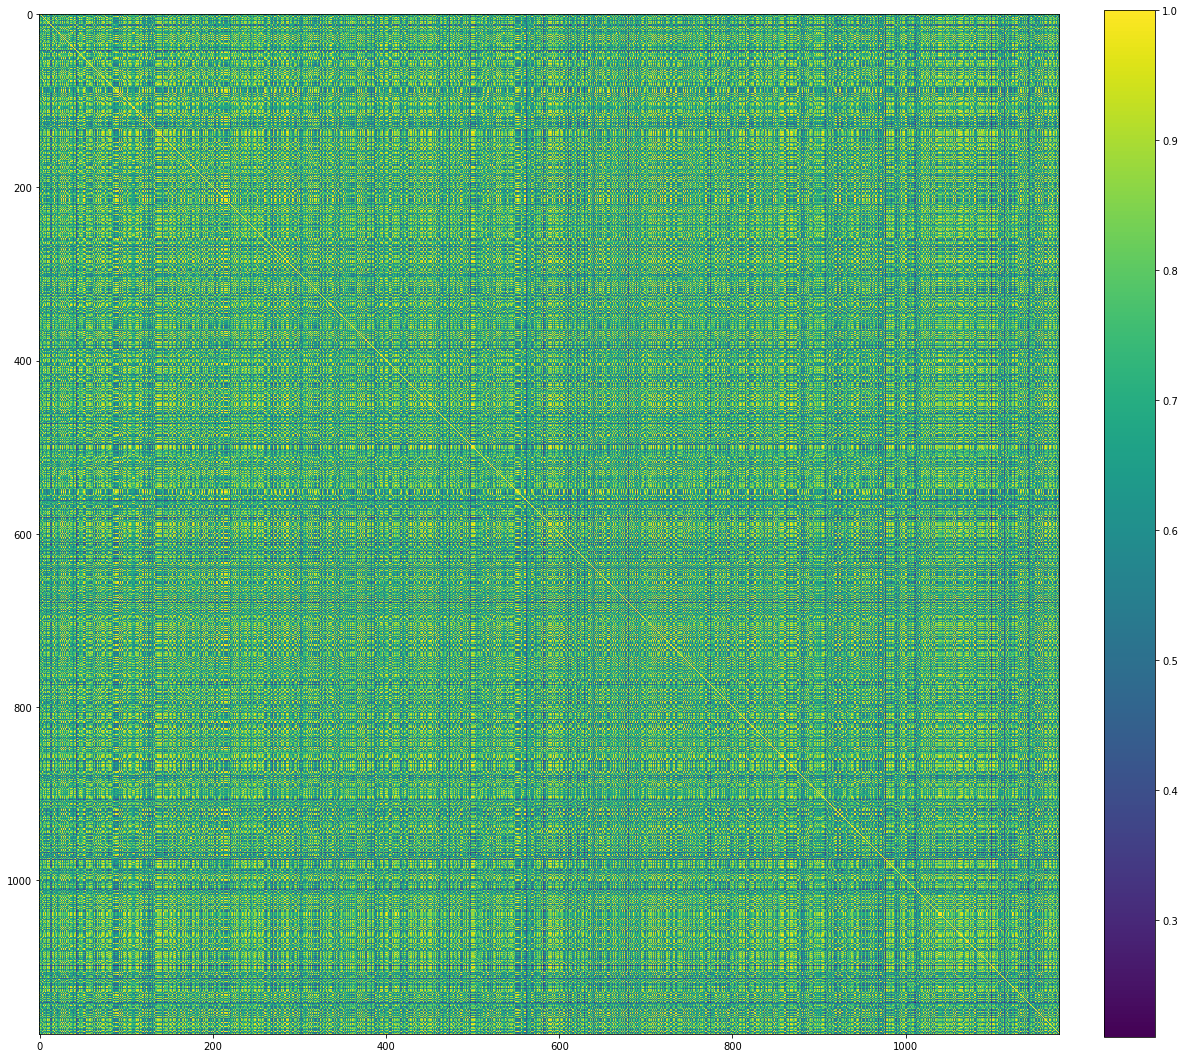

In [16]:
plt.figure(1, figsize=(20,20))
heatmap=plt.imshow(similarities, cmap='viridis', interpolation='nearest')
plt.colorbar(heatmap,fraction=0.046, pad=0.04)
plt.show()

#### Dump similarity matrix for further (quick) re-use

Dump the matrix

In [25]:
#with open('Clustering/SimilarityMatrix.pkl', 'wb') as fp : # wb for "write bytes"
#    pickle.dump(similarities, fp)

Load the matrix

In [26]:
#with open ('Clustering/SimilarityMatrix.pkl', 'rb') as fp:
#     similarities = pickle.load(fp)

### 4.2 Initialize the clustering algorithm

In [21]:
numberOfUsers=len(similarities)
print(numberOfUsers)

1178


In [37]:
nL=0 #number of cluster at iteration l
CCS=[] #List of Medoids
clusterList=np.zeros((numberOfUsers,)) #List of cluster assignation
sumOfSim=np.zeros((numberOfUsers,)) #Sum of similarities columns
rL_history=[] #History of RL ratio
ratioNL_history=[] #History of NL ratio
gammaL_history=[] #History of GammaL ratio
sumRLNL=[] #History of rL+NL

In [38]:
#Calculate sum of similarities for each column | Once calculated, it doesn't change and is, thus, re-usable
for i in range(numberOfUsers) :
    tempSum=np.sum(similarities[:,i])
    sumOfSim[i]=tempSum

In [39]:
#Get the most similar and least similar object to others (=> First two medoids)
maxOfSumSim=np.amax(sumOfSim)
indexMax=np.argmax(sumOfSim)
minOfSumSim=np.amin(sumOfSim)
indexMin=np.argmin(sumOfSim)

for i in range(numberOfUsers): #Firstly, we only assign all the items to the medoids with the highest sum of similarities with others (Genesis cluster)
    clusterList[i]=indexMax

nL+=1 #Add one to n° of cluster cause there's one global cluster (but add nothing to CCS as this first assignement is only to compute Gamma0) and assign everyone to genesis cluster (the one with the biggest SumOfSim)

gamma0=maxOfSumSim #For stop condition used later

#Compute system ratios for the genesis cluster
#tempRatioRL=calculateSimilarityRatioRL(clusterList=clusterList,gamma0=gamma0,similarities=similarities)
tempRatioRL=calculateSimilarityRatioRL(clusterList=clusterList,gamma0=gamma0,similarities=similarities)
rL_history.append(tempRatioRL)
tempRatioNL=nL/numberOfUsers
ratioNL_history.append(tempRatioNL)
tempGammaL=calculateGammaL(clusterList=clusterList,similarities=similarities)
gammaL_history.append(tempGammaL)
tempSumRLNL=tempRatioRL+tempRatioNL
sumRLNL.append(tempSumRLNL)

print("Genesis RL :",tempRatioRL,"| Genesis Ratio NL :",tempRatioNL,"| Genesis RL + Ratio NL :",tempSumRLNL,"| Genesis GammaL (=Gamma0) :",tempGammaL)
print("Max in",indexMax,":",maxOfSumSim,"| Min in",indexMin,":",minOfSumSim," | Gamma0 is :",gamma0)

#Add the two medoids to initizialize the bissecting process
CCS.append(indexMax)
CCS.append(indexMin)
nL+=1 #Only increase by one because we have delete the genesis cluster and add two new cluster => 1-1+2=2

Genesis RL : 1.0 | Genesis Ratio NL : 0.0008488964346349745 | Genesis RL + Ratio NL : 1.00084889643 | Genesis GammaL (=Gamma0) : 909.638448988
Max in 113 : 909.638448988 | Min in 976 : 523.744521123  | Gamma0 is : 909.638448988


In [40]:
#Assign every object to the good cluster
for i in range(numberOfUsers):
    similarityWithMax=similarities[i,indexMax]
    similarityWithMin=similarities[i,indexMin]

    #if similarityWithMax>similarityWithMin:
    if  similarityWithMax>0.92 and similarityWithMax>similarityWithMin : # similarityWithMax>0.90 and   for excluding even other high similarity item
        clusterList[i]=indexMax
    else:
        clusterList[i]=indexMin

In [41]:
#Compute system ratios 
tempRatioRL=calculateSimilarityRatioRL(clusterList=clusterList,gamma0=gamma0,similarities=similarities)
rL_history.append(tempRatioRL)
tempRatioNL=nL/numberOfUsers
ratioNL_history.append(tempRatioNL)
tempGammaL=calculateGammaL(clusterList=clusterList,similarities=similarities)
gammaL_history.append(tempGammaL)
tempSumRLNL=tempRatioRL+tempRatioNL
sumRLNL.append(tempSumRLNL)

print("First2 clusters RL :",tempRatioRL,"| First2 clusters Ratio NL :",tempRatioNL,"| First2 clusters RL + Ratio NL :",tempSumRLNL,"| First2 clusters GammaL (=Gamma0) :",tempGammaL)

First2 clusters RL : 1.45646293045 | First2 clusters Ratio NL : 0.001697792869269949 | First2 clusters RL + Ratio NL : 1.45816072332 | First2 clusters GammaL (=Gamma0) : 312.276553686


In [42]:
print("Current clustering state :")
clusters, countsClusters=np.unique(clusterList, return_counts=True)
print("Clusters :",clusters)
print("Counts :",countsClusters)

Current clustering state :
Clusters : [ 113.  976.]
Counts : [ 172 1006]


### 4.3 Looping the algorithm until convergence

In [47]:
nn=[11,55,44,1,2,8,3]
for lm in nn:
    
    if lm in range(0,4):
        print(lm)

1
2
3


In [48]:
debug=False
#numberOfClusterStop=len(clusterList) #Cluster number simple condition
numberOfClusterStop=5

In [51]:
isOver=False
oldCCS=[]
oldClusterlist=[]
#previous_state_clusters_count=[]
#previous_state_clusters=[]

while(isOver==False):

    #'''
    cs=[list(clusterList).count(nn) for nn in list(np.unique(clusterList))]
    print(cs)
    if np.min(cs) not in range(0,4):
        print(np.min(cs))
        best_cluster_list=clusterList
    #''' 
   
    print('count: ',[list(clusterList).count(nn) for nn in list(np.unique(clusterList))])
        
    print('med: ',np.unique(clusterList))
    
    if(debug==False):
        #clear_output(wait=True)
        print("Current clustering state - nL :",nL)#, end='\r')
    #print([list(clusterList).count(nn) for nn in list(np.unique(clusterList))])

    
    
    clusters, countsClusters=np.unique(clusterList, return_counts=True)

    
    oldCCS=[]
    oldClusterlist=[]
    oldCCS.extend(CCS)
    oldClusterlist.extend(clusterList)
    
    #Calculate Avg similarity for each cluster
    clusterAvgSimiliraty={}
    for i in CCS :
        clusterAvgSimiliraty[i]=calculateClusterAvgSimilarity(clusterList=clusterList,clusterMedoidID=i,similarities=similarities)   
    
    #Detect the "weakest" cluster, delete it, and assign NaN to items that were in it
    weakestCluster=min(clusterAvgSimiliraty, key=clusterAvgSimiliraty.get)
    
    if(debug==True):
        print("Average similarities :",clusterAvgSimiliraty)
        print("Weakest medoid is :",weakestCluster)
        print("")
        
    CCS.remove(weakestCluster)
    
    #All the undefined cluster items are potential medoid candidates
    newMedoidsCandidates=[]
    
    #Set the cluster assignation to NaN and append the element to medoid candidates array
    for index,i in enumerate(clusterList) :
        if(i==weakestCluster):
            newMedoidsCandidates.append(index)# pic up all indexes of weak cluster
    
    if(debug==True):
        print("New medoid candidates are  :",newMedoidsCandidates)
    
    #Retrieve candidates sum of similarities
    candidatesSumOfSim=[]
    
    for i in newMedoidsCandidates:
        candidatesSumOfSim.append(sumOfSim[i])
    
    #Detect min and max of sum of similiraties (=> The two new medoids)
    maxSimSumCandidate=np.amax(candidatesSumOfSim)
    inArrayMaxSimSumCandidate=np.argmax(candidatesSumOfSim)
    indexMaxSimSumCandidate=newMedoidsCandidates[inArrayMaxSimSumCandidate]
    
    minSimSumCandidate=np.amin(candidatesSumOfSim)
    inArrayMinSimSumCandidate=np.argmin(candidatesSumOfSim)
    indexMinSimSumCandidate=newMedoidsCandidates[inArrayMinSimSumCandidate]
    
    if(debug==True):
        print("Strongest medoid candidate is :",indexMaxSimSumCandidate,"| Weakest medoid candidate is :",indexMinSimSumCandidate)
    
    #Add the two medoids to medoids array and increase nl (one delete, two added => +1)
    CCS.append(indexMaxSimSumCandidate)
    CCS.append(indexMinSimSumCandidate)
    nL+=1
    
    #Reassign all the items to the most similar medoid (Alternative version of bissecting algorithm with full reassignement, Steinbach and al. 2000)
    for count,i in enumerate(clusterList):
        pointSimilarityWithCenters={}
        for j in CCS:
            pointSimilarityWithCenters[j]=similarities[count,j]
        closestCluster=max(pointSimilarityWithCenters, key=pointSimilarityWithCenters.get)
        clusterList[count]=closestCluster  
        
    #Compute system ratios 
    #tempRatioRL=calculateSimilarityRatioRL(clusterList=clusterList,gamma0=gamma0,similarities=similarities)
    tempRatioRL=calculateSimilarityRatioRL(clusterList=clusterList,gamma0=gamma0,similarities=similarities)
    rL_history.append(tempRatioRL)
    tempRatioNL=nL/numberOfUsers
    ratioNL_history.append(tempRatioNL)
    tempGammaL=calculateGammaL(clusterList=clusterList,similarities=similarities)
    gammaL_history.append(tempGammaL)
    tempSumRLNL=tempRatioRL+tempRatioNL
    sumRLNL.append(tempSumRLNL)
    
    if(debug==True):
        print("")
        print("RL :",tempRatioRL,"| Ratio NL :",tempRatioNL,"| GammaL :",tempGammaL,"| RL+Ratio NL :",tempSumRLNL)

    #Check the stop conditions
    
    #Cluster number #unitiy existance# condition 
  

        
    if (nL==numberOfClusterStop)  or np.min(cs)==1:
        isOver=True

    

 

[172, 1006]
172
count:  [172, 1006]
med:  [ 113.  976.]
Current clustering state - nL : 2
[762, 387, 29]
29
count:  [762, 387, 29]
med:  [ 113.  230.  976.]
Current clustering state - nL : 3
[755, 195, 8, 220]
8
count:  [755, 195, 8, 220]
med:  [ 113.  230.  976.  992.]
Current clustering state - nL : 4


In [68]:
np.unique(oldClusterlist)

array([ 113.,  230.,  976.,  992.])

In [69]:
np.unique(clusterList)

array([  113.,   230.,   976.,   992.,  1142.])

In [72]:
dist=1-similarities

In [100]:
from sklearn.cluster import SpectralClustering
aff_matrix=similarities
Cluster = SpectralClustering(n_clusters=6, affinity='precomputed')
labels = Cluster.fit_predict(aff_matrix)

In [101]:
len(labels)

1178

In [102]:
[list(labels).count(nn) for nn in list(np.unique(labels))]


[211, 337, 216, 135, 198, 81]

In [ ]:
for count,i in enumerate(clusterList):
        pointSimilarityWithCenters={}
        for j in CCS:
            pointSimilarityWithCenters[j]=similarities[count,j]
        closestCluster=max(pointSimilarityWithCenters, key=pointSimilarityWithCenters.get)
        clusterList[count]=closestCluster  
        
    

In [57]:
for count,i in enumerate(clusterList):
    pointSimilarityWithCenters={}
    for j in CCS:
        pointSimilarityWithCenters[j]=similarities[count,j]


In [59]:
pointSimilarityWithCenters

{113: 0.93939393939393945,
 230: 0.81818181818181812,
 976: 0.39534883720930236,
 992: 0.58064516129032262,
 1142: 0.59615384615384615}

In [55]:
CCS

[113, 230, 992, 1142, 976]

In [35]:
def simi(s1,s2,q):
    return (diff.SequenceMatcher(None,s1,s2).ratio()
                                 +
                                 q_grams_similarity(s1,s2,q))/2

In [36]:
q=1

In [37]:
# join one_case cluster withe the most similar:

med=[]
array1=best_cluster_list
for m in np.unique(best_cluster_list):
    med.append(int(m))
cc=[list(best_cluster_list).count(nn) for nn in list(np.unique(best_cluster_list))]

while list(cc).count(1) :

    ln=len(cc)
    for i in range(ln):
        if cc[i]==1:

            s1=Activities_train[med[i]]
            sims=np.zeros(len(med))
            for j in range(len(sims)):
                if i==j:
                    continue
                else:
                    s2=Activities_train[med[j]]
                    sims[j]=simi(s1,s2,q)
                maxi=np.argmax(sims)
                array1=np.where(array1==med[i], med[maxi], array1) 


            med=[]
            for m in np.unique(array1):
                med.append(int(m))
            print('med: ',med)
            cc=[list(array1).count(nn) for nn in list(np.unique(array1))]
            print('count: ',cc)
            break




med:  [113, 255, 383, 431, 463, 620, 976, 1021, 1092, 1098]
count:  [333, 155, 12, 41, 76, 369, 3, 127, 61, 1]
med:  [113, 255, 383, 431, 463, 620, 976, 1021, 1092]
count:  [334, 155, 12, 41, 76, 369, 3, 127, 61]


In [38]:
np.unique(array1)


array([  113.,   255.,   383.,   431.,   463.,   620.,   976.,  1021.,
        1092.])

In [39]:
np.array([list(array1).count(nn) for nn in list(np.unique(array1))]).transpose()

array([334, 155,  12,  41,  76, 369,   3, 127,  61])

In [40]:
medoide_table=pd.DataFrame(columns=['index','Case ID','Activity'])
medoide_table['index']=med
medoide_table['Case ID']=list(Activities_train.index[med])
medoide_table['Activity']=list(Activities_train[med])
medoide_table

,index,Case ID,Activity
0,113,Application_1995055505,¥©¤¶¡­®±´£ºª°µ§«¨
1,255,Application_577491572,¥¶¤¡­®±´£ºª°µ§ºª¦¯
2,383,Application_164664961,¥©¤¶¡­®­®±±´£­®­®±±ºª°¦¯¯¯¯
3,431,Application_1056033042,¥©¤¶¡­®±´£­®±ºª°ºµ§ºªµ§ºªµ§ºªµ§ºª«¨¬
4,463,Application_263637487,¥¶¤¡­®±´£­®±ºª°º«¨¬
5,620,Application_1135538592,¥©¤¶¡­®±´£­®²¢¬¬
6,976,Application_1048834285,¥¶¤¡­®²´£­®±­®²­®²­®²¢¬¬¬¬¬
7,1021,Application_2041978198,¥©¤¶¡­®±´£ºª°µ§ºªµ§¢¬
8,1092,Application_1565641655,¥©¤¶¡­®±´£­®²­®±¬¬ºª°µ§ºªµ§ºª«¨


In [41]:
# for filling empty encoded columns
###################################
all_users=pd.Series(data['Resource'].values).unique()#   one time
all_goal=pd.Series(data['(case) LoanGoal'].values).unique()
all_types=pd.Series(data['(case) ApplicationType'].values).unique()
global d1

d=list(['Resource_'+str(u) for u in all_users  ])
d1=list(['(case) LoanGoal_'+str(u) for u in all_goal  ])
d2=list(['(case) ApplicationType_'+str(u) for u in all_types  ])

for i in d:
    d1.append(i)
for i in d2:
    d1.append(i)


In [42]:
data_encoder = LastStateEncoder(case_id_col, timestamp_col, cat_cols, numeric_cols, fillna=True)

In [43]:
clss = [RandomForestClassifier(n_estimators=100, random_state=22) for _ in med]
cluster_assignments=np.array(array1 )
# encoding only the trains set
train_encode=data_encoder.transform(train_KMedoide)
# encoding all set for extracting all potntial features
#all_encode=train_KMedoide
#all_encode=all_encode.append(test_KMedoide)
all_encode=data[data['Case ID'].isin(sample_cases_KMedoide)]
all_encode=data_encoder.transform(all_encode)
cls_features=all_encode.columns
# adding lost features
missing_columns=[col for col in d1 if col not in list(cls_features)]
mc=pd.DataFrame(columns=missing_columns)
train_encode=pd.concat([train_encode,mc],ignore_index=True, sort=False).fillna(0)

In [44]:
#encode from 0->n to retrieve real medoide to use it further for aut complete as a standard case of cluster

from sklearn.preprocessing import LabelEncoder
cls_make = LabelEncoder()
clustered= cls_make.fit_transform(array1)

In [46]:
for cl in range(cls_make.classes_.shape[0]):
    cases = ac_lbl[clustered == cl]['Case ID']
    tmp = train_encode[train_encode[case_id_col].isin(cases)]
    clss[cl].fit(tmp.drop([case_id_col, label_col], axis=1), tmp[label_col])

# now lest test our model:

In [47]:
# fit finished
#then predict:

In [436]:
# events from '''''''  to '''''''
#if not: from_event=A_Create Application

act=dict([(x,i) for i,x in enumerate(lb_make.classes_) ])
#test_KMedoide.drop(['Complete Timestamp'],axis=1,inplace=True)
#test_cases_KMedoide=test_KMedoide['Case ID'].unique()


from_event= act['A_Submitted']

to_event  = act['A_Accepted']

from_to=pd.DataFrame(columns=test_KMedoide.columns)
#idx=dd[dd['Activity'].values==from_event].index
#idx2=dd[dd['Activity'].values==to_event].index  
#cd=test_KMeans[test_KMeans.index.isin (range(idx[0],idx2[0]+1))]

for i in test_cases_KMedoide:
    dd=test_KMedoide[test_KMedoide['Case ID']==i]
    idx=dd[dd['Activity']==from_event].index
    if not idx.any():
        idx=dd[dd['Activity'].values==act['A_Create Application']].index
    idx2=dd[dd['Activity']==to_event].index 
    from_to=from_to.append(test_KMedoide[test_KMedoide.index.isin (range(idx[0],idx2[0]+1))])

In [437]:
# events from '''''''  to '''''''
#if not: from_event=A_Create Application

from_event= act[ 'A_Accepted']

to_event  = act['O_Sent (mail and online)']

#from_to=pd.DataFrame(columns=test_KMedoide.columns)
#idx=dd[dd['Activity'].values==from_event].index
#idx2=dd[dd['Activity'].values==to_event].index  
#cd=test_KMeans[test_KMeans.index.isin (range(idx[0],idx2[0]+1))]

for i in test_cases_KMedoide:
    dd=test_KMedoide[test_KMedoide['Case ID']==i]
    idx=dd[dd['Activity'].values==from_event].index+1
    if not idx.any():
        idx=dd[dd['Activity'].values==act['A_Create Application']].index+1
    idx2=dd[dd['Activity'].values==to_event].index 
    if not idx2.any():
        idx2=dd[dd['Activity'].values==act['O_Sent (online only)']].index
    if not idx2.any():
        idx2=dd[dd['Activity'].values==act['O_Created']].index
    from_to=from_to.append(test_KMedoide[test_KMedoide.index.isin (range(idx[0],idx2[0]+1))])

In [438]:
# events from '''''''  to '''''''
#if not: from_event=A_Create Application

from_event= act['A_Validating']

to_event  = act['A_Pending']

#from_to=pd.DataFrame(columns=test_KMedoide.columns)
#idx=dd[dd['Activity'].values==from_event].index
#idx2=dd[dd['Activity'].values==to_event].index  
#cd=test_KMeans[test_KMeans.index.isin (range(idx[0],idx2[0]+1))]

for i in test_cases_KMedoide:
    dd=test_KMedoide[test_KMedoide['Case ID']==i]
    idx=dd[dd['Activity'].values==from_event].index
    if not idx.any():
        idx=dd[dd['Activity'].values==act['W_Call after offers']].index
    if not idx.any():
        idx=dd[dd['Activity'].values==act['W_Complete application']].index
        
    if not idx.any():
        idx=dd[dd['Activity'].values==act['W_Shortened completion']].index    
    
    idx2=dd[dd['Activity'].values==to_event].index 
    if not idx2.any():
        idx2=dd[dd['Activity'].values==act['A_Denied']].index
    if not idx2.any():
        idx2=dd[dd['Activity'].values==act['A_Cancelled']].index
    if not idx2.any():
        idx2=dd.index.max()
    from_to=from_to.append(test_KMedoide[test_KMedoide.index.isin (range(idx[0],idx2[0]+1))])

In [424]:
# trim first n activity
#######################

n=14

n_events=pd.DataFrame(columns=test_KMedoide.columns)
for i in test_cases_KMedoide:
    #cc=test_KMeans[test_KMeans['Case ID']==i]
    n_events=n_events.append(test_KMedoide[test_KMedoide['Case ID']==i][8:n])
#n_events=test_KMedoide[test_KMedoide.index.isin(n_events.index) ]


In [425]:
from_to=n_events

In [439]:
def trace(x):
    l=''
    for ac in x['Activity']:
        l+=chr(int(ac)+ascii_offset)
    return l


ascii_offset=161

# aggregate activities by case
grouped = from_to.groupby(['Case ID'], sort=False)

# extract  encoded trace from actvities
Activities_test = grouped.apply(lambda x: trace(x) )

In [440]:
label = from_to.groupby(['Case ID'],sort=False).first()['lbl']

In [441]:
ac_lbl=pd.DataFrame(columns=['Case ID','Activity','lbl'])
ac_lbl['Case ID']=Activities_test.index
ac_lbl['Activity']=list(Activities_test)
ac_lbl['lbl']=list(label)
ac_lbl.head()

,Case ID,Activity,lbl
0,Application_1266995739,©¤¶¡­®±ª°µ§¢,A_Cancelled
1,Application_798605556,©¤¶¡­®±´£¢,A_Cancelled
2,Application_2092350091,©¤¶¡­®­®±´£­®±¢,A_Cancelled
3,Application_1231200933,©¤¶¡­®±´£­®±¢,A_Cancelled
4,Application_448701611,©¤¶¡­®±´£¢,A_Cancelled


In [442]:
# encoding name of cluster implicitely cluster name = np.argmax(sim)  it may neglagate a cluster if not max anytime!!


clustered_test=[]

for i in  range(ac_lbl.shape[0]) :
    sim=[]
    for j in range(len(medoide_table)):
        sim.append(simi(ac_lbl['Activity'][i],medoide_table['Activity'][j], q))
    clustered_test.append(np.argmax(sim))
clusters_names=np.unique(clustered_test)

print('distribution of test elements: ', [clustered_test.count(k) for k in clusters_names ])

distribution of test elements:  [106, 45, 1, 5, 5, 88, 13, 7]


In [443]:
# predict outcomes for each cluster
cols = ['Case ID']+list(clss[0].classes_)
preds = pd.DataFrame(columns=cols)
actual = pd.DataFrame(columns=cols)

In [444]:
data_encoder = LastStateEncoder(case_id_col, timestamp_col, cat_cols, numeric_cols, fillna=True)

In [445]:
# for filling empty encoded columns
###################################
all_users=pd.Series(data['Resource'].values).unique()#   one time
all_goal=pd.Series(data['(case) LoanGoal'].values).unique()
all_types=pd.Series(data['(case) ApplicationType'].values).unique()
#global d1

d=list(['Resource_'+str(u) for u in all_users  ])
d1=list(['(case) LoanGoal_'+str(u) for u in all_goal  ])
d2=list(['(case) ApplicationType_'+str(u) for u in all_types  ])

for i in d:
    d1.append(i)
for i in d2:
    d1.append(i)


In [446]:
clusters_names

array([0, 1, 2, 3, 4, 5, 7, 8], dtype=int64)

In [447]:
cluster_assignments=np.array(clustered_test )
#test_KMedoide1.index=test_KMedoide['Case ID']

for cl in clusters_names:
    
    cases = ac_lbl[cluster_assignments == cl]['Case ID']
    tmp = from_to[from_to[case_id_col].isin(cases)]
    test_encode = data_encoder.transform(tmp)
    
    missing_columns=[col for col in d1 if col not in test_encode.columns]
    mc=pd.DataFrame(columns=missing_columns)
    test_encode=pd.concat([test_encode,mc],ignore_index=True, sort=False).fillna(0)
    test_encode.fillna(0, inplace=True)
    
    new_preds = pd.DataFrame(clss[cl].predict_proba(test_encode.drop([case_id_col, label_col], axis=1)))
    new_preds.columns = clss[cl].classes_
    new_preds[case_id_col] = list(test_encode['Case ID'])
    preds = pd.concat([preds, new_preds], axis=0, ignore_index=True,sort=False)
    
    actuals = pd.get_dummies(test_encode[label_col])
    actuals[case_id_col] = test_encode[case_id_col]
    actual = pd.concat([actual, actuals], axis=0, ignore_index=True,sort=False)
    
preds.fillna(0, inplace=True)
actual.fillna(0, inplace=True)

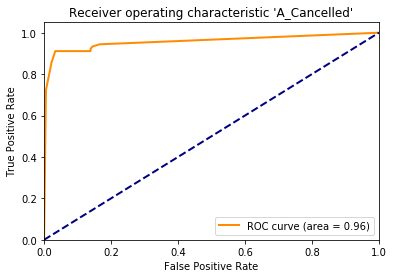

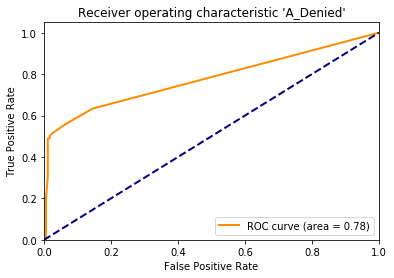

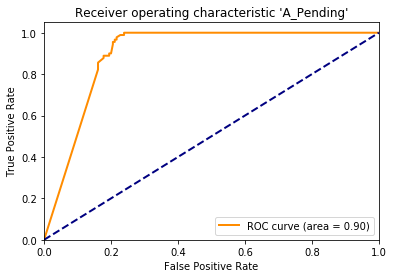

In [448]:
import sklearn.metrics as met
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
th=dict()
roc_auc = dict()
for i in range(3):
    fpr[i], tpr[i],th[i] = met.roc_curve(actual[actual.columns.values[i+1]],preds[preds.columns.values[i+1]])
    roc_auc[i] = auc(fpr[i], tpr[i])

for i in range(3):
    plt.figure()
    lw = i
    plt.plot(fpr[i], tpr[i], color='darkorange',
             lw=2, label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic %r' %actual.columns.values[i+1])
    plt.legend(loc="lower right")
    plt.show()

# Resalts

In [38]:
# KMedoide start predicting the outcome correctely begining by n_events = 11 activities.
# However it cas significantly predict outcome by 6 activities after common begining of all application

# KMedoide doesn't able to predict the outcome when the request present the system fault from 'A_Submitted' to 'A_Accepted'.
# KMedoide doesn't able to predict the outcome when the request present the system fault from 'A_Accepted' to O_Sent.
# KMedoide can predect outcome in an acceptable rate when the request present the system fault from'A_Validating' to desision.

# KMedoide shows a good rate to estimate outcome by feading model in a system delay activities.

# More the activities in the trace, more prediction precies since the clustering depends on activities weights


# 88% avg correct prediction by three classes for test data AP=90 AD=90 AC=90 tot=270

In [344]:
print(list(ac_lbl['lbl']).count('A_Cancelled'))
print(list(ac_lbl['lbl']).count('A_Pending'))
print(list(ac_lbl['lbl']).count('A_Denied'))

284
414
90


In [359]:
dddd='A_Cancelled'
AC=test_KMedoide[test_KMedoide['Case ID'].isin(ac_lbl[ac_lbl['lbl']==dddd]['Case ID'][0:90])]
dddd='A_Pending'
AP=test_KMedoide[test_KMedoide['Case ID'].isin(ac_lbl[ac_lbl['lbl']==dddd]['Case ID'][0:90])]
dddd='A_Denied'
AD=test_KMedoide[test_KMedoide['Case ID'].isin(ac_lbl[ac_lbl['lbl']==dddd]['Case ID'][0:90])]
AC=pd.concat([AC,AP],axis=0)
AC=pd.concat([AC,AD],axis=0)

In [361]:
test_KMedoide=  AC

In [450]:
test_cases_KMedoide.shape

(270,)